In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imorting Libraries

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2025-05-23 17:26:52.900899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748021213.172322      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748021213.257797      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import tensorflow as tf

# Creating Dataframe

In [5]:
train_dir = '/kaggle/input/soil-classification/soil_classification-2025/train'
test_dir = '/kaggle/input/soil-classification/soil_classification-2025/test'
train_csv_path = '/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv'
test_csv_path = '/kaggle/input/soil-classification/soil_classification-2025/test_ids.csv'

In [6]:
# Load the CSV files
train_df = pd.read_csv(train_csv_path)
test_ids_df = pd.read_csv(test_csv_path)

In [7]:
train_df.head()

,image_id,soil_type
0,img_ed005410.jpg,Alluvial soil
1,img_0c5ecd2a.jpg,Alluvial soil
2,img_ed713bb5.jpg,Alluvial soil
3,img_12c58874.jpg,Alluvial soil
4,img_eff357af.jpg,Alluvial soil


# Some EDA

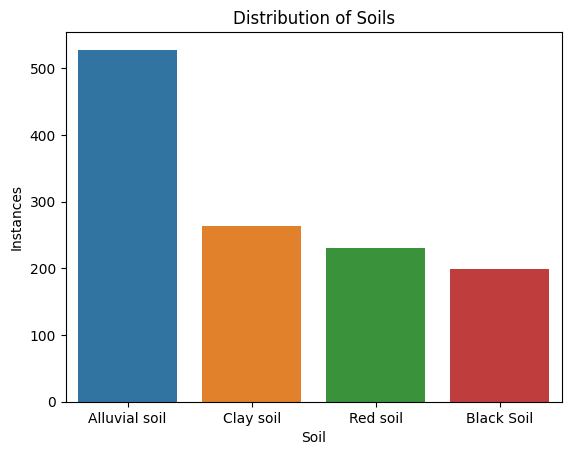

In [8]:
sns.barplot(x=train_df['soil_type'].unique(), y=train_df['soil_type'].value_counts())
plt.title("Distribution of Soils")
plt.xlabel("Soil")
plt.ylabel("Instances")
plt.show()

In [9]:
from PIL import Image

In [10]:
def visualise(soil):
    filtered = train_df[train_df['soil_type'] == soil].head(1)
    if not filtered.empty:
        image_file = filtered['image_id'].values[0]
        image_path = os.path.join(train_dir, image_file)
        
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(soil)
        plt.show()
    else:
        print(f"No images found for soil type: {soil}")

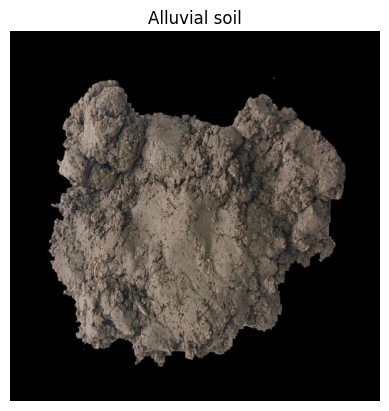

In [11]:
visualise("Alluvial soil")

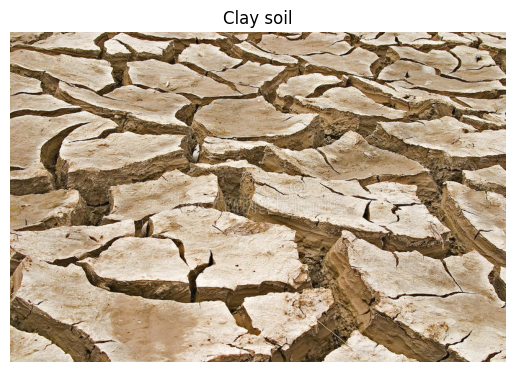

In [12]:
visualise("Clay soil")

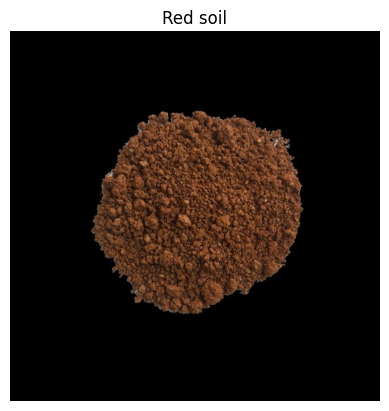

In [13]:
visualise("Red soil")

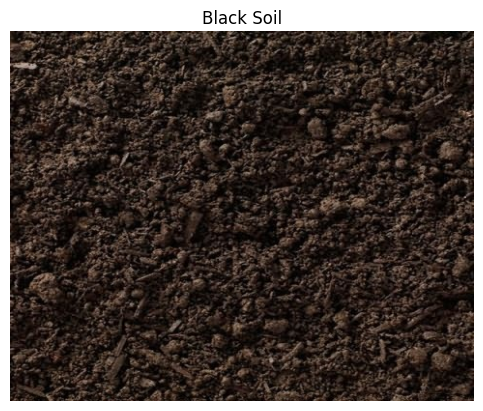

In [14]:
visualise("Black Soil")

# Loading Data

In [15]:
categories = ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']


In [16]:
def load_data(data_dir, labels_df, is_train=True):
    images = []
    labels = []
    for index, row in labels_df.iterrows():
        img_id = row['image_id'] 
        img_path = os.path.join(data_dir, img_id)
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Error: Could not load image {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, (224, 224))  # Resize to 224x224
            images.append(img)
            if is_train:
                label = row['soil_type']  # <- Use the correct column name
                if label not in categories:
                    print(f"Warning: Label '{label}' not in categories list. Skipping this image.")
                    continue
                class_num = categories.index(label)
                labels.append(class_num)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    if is_train:
        images = np.array(images)
        labels = np.array(labels, dtype=np.int32)
        return images, labels
    else:
        return np.array(images)

# Load train data 
X_train, y_train = load_data(train_dir, train_df, is_train=True)

# Load test data 
X_test = load_data(test_dir, test_ids_df, is_train=False)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

In [17]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# 2. Convert to tf.data.Dataset
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Helper function to wrap images and labels
def prepare_dataset(images, labels, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

train_ds = prepare_dataset(X_train_split, y_train_split, is_training=True)
val_ds = prepare_dataset(X_val_split, y_val_split, is_training=False)

I0000 00:00:1748021292.188871      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Transfer Learning

**Defining the Model**

In [18]:
from tensorflow.keras.regularizers import l2 #regularization to prevent overfitting

In [19]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax',kernel_regularizer=l2(0.001))
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


**Compilation**

In [20]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


**Model Summary**

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,426,212 (9.26 MB)

 Trainable params: 168,228 (657.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [22]:
early_stop = EarlyStopping(
    monitor='val_loss',      # or 'val_accuracy'
    patience=3,              # stop if no improvement for 3 epochs
    restore_best_weights=True # restore best weights
)

**Training**

In [23]:
history=model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stop])

Epoch 1/100


I0000 00:00:1748021307.645173     127 service.cc:148] XLA service 0x7db648245060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748021307.646174     127 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748021308.596512     127 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2239 - loss: 2.1440

I0000 00:00:1748021313.583904     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 408ms/step - accuracy: 0.4504 - loss: 1.6212 - val_accuracy: 0.7878 - val_loss: 0.8377
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7501 - loss: 0.9146 - val_accuracy: 0.8735 - val_loss: 0.6575
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8148 - loss: 0.7219 - val_accuracy: 0.8980 - val_loss: 0.5511
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8800 - loss: 0.5871 - val_accuracy: 0.8939 - val_loss: 0.5127
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9153 - loss: 0.4790 - val_accuracy: 0.9347 - val_loss: 0.4361
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9309 - loss: 0.4638 - val_accuracy: 0.9265 - val_loss: 0.4310
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9345 - loss: 0.4329 - val_accuracy: 0.9388 - val_loss: 0.4174
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9475 - loss: 0.3768 - val_accuracy: 0.9388 - val

# Some Post EDA

**Plot of Accuracy and Loss**

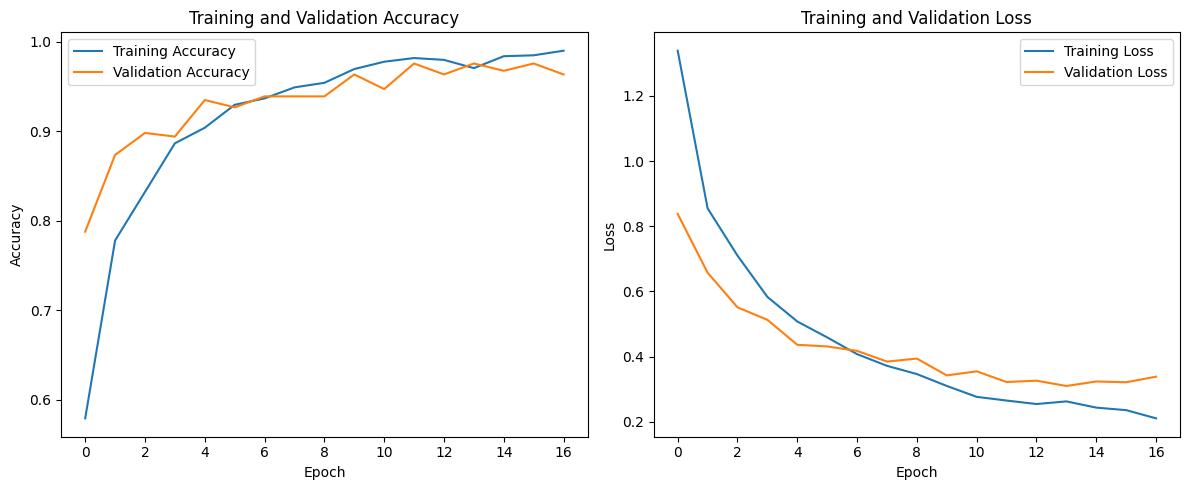

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Confusion Matrix**

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


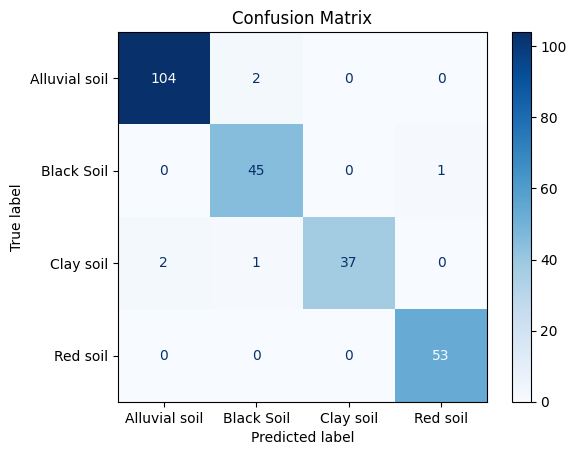

In [26]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

**Calculating training f1-score**

In [27]:
from sklearn.metrics import f1_score


y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Compute F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score (weighted): {f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
F1 Score (weighted): 0.9755


# Creating submission file

In [28]:
test_predictions=model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [29]:
classes=[]
for x in test_predictions:
    pred=np.argmax(x)
    pred=categories[pred]
    classes.append(pred)

In [30]:
test_ids_df['soil_type']=classes

In [31]:
test_ids_df

,image_id,soil_type
0,img_cdf80d6f.jpeg,Alluvial soil
1,img_c0142a80.jpg,Alluvial soil
2,img_91168fb0.jpg,Alluvial soil
3,img_9822190f.jpg,Alluvial soil
4,img_e5fc436c.jpeg,Alluvial soil
...,...,...
336,img_bc768d49.jpg,Black Soil
337,img_ddef2a37.jpg,Black Soil
338,img_be2e7e88.jpg,Black Soil
339,img_04f21bb9.jpg,Black Soil


**Saving the Submission**

In [32]:
test_ids_df.to_csv("/kaggle/working/Submission3.csv")

In [34]:
model.save("/kaggle/working/SoilClassifier.h5")

# Visualing tests

In [35]:
def visualiseTest(num):
    image_file = test_ids_df['image_id'].iloc[num]
    image_path = os.path.join(test_dir, image_file)
    
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(test_ids_df['soil_type'].iloc[num])
    plt.show()

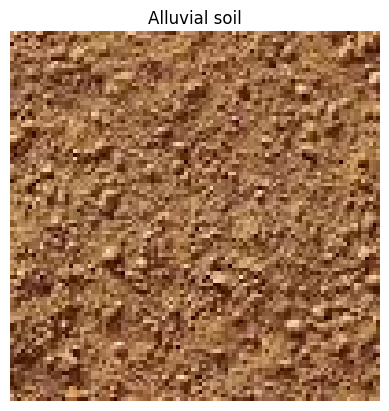

In [36]:
visualiseTest(4)

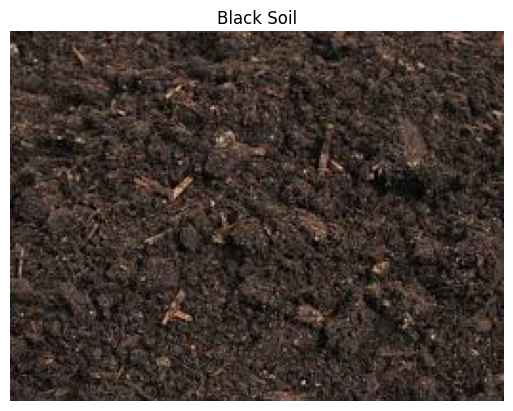

In [37]:
visualiseTest(334)

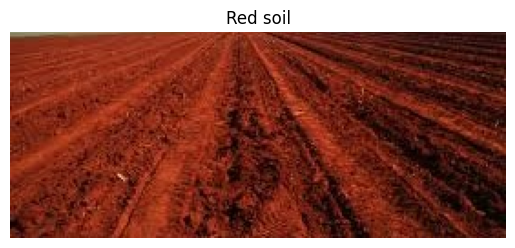

In [39]:
visualiseTest(201)

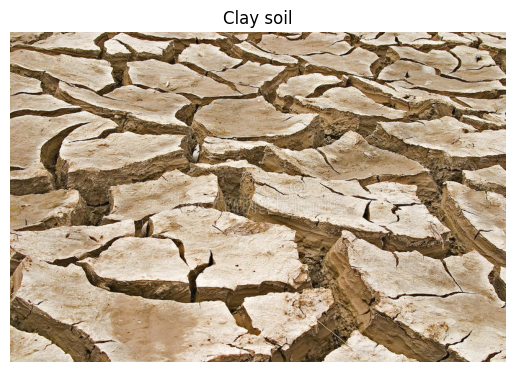

In [40]:
visualiseTest(105)